### Next character prediction using a multi layer perceptron

From https://www.youtube.com/watch?v=TCH_1BHY58I&t=1174s&ab_channel=AndrejKarpathy 

Inspired by the Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [147]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [148]:
len(words)

32033

In [149]:
# Notes on sets
exSet = {23, 123, 23}
print(exSet, type(exSet), len(exSet)) 
# set in python are unnordered collection of unique elements that's why the len of exSet is 2
# as they are unnordered, they are not indexed 
# exSet[0] # doesn't work for that reason  
# we can update them 
exSet.add(1)
print(exSet)
exSet.remove(1)
print(exSet)
# we can verify the existence of an element in the set
print(123 in exSet)

{123, 23} <class 'set'> 2
{1, 123, 23}
{123, 23}
True


In [150]:
# Notes on enumerate
# it's used to add a counter on any subscriptable (such as a list) 
# and it returns this subscriptable as an enumerate object
# An enumerate object can then be used to obtain both the value and the index 

l =  ['a', 'b', 'c', 'd']
print(type(enumerate(l)))

for index, value in enumerate(l):
    print(index,value)

# this is the basic way to create the dict associated to this enumeration
dict = {}
print(enumerate(l))
for i,s in enumerate(l):
    print(i,s)
    dict[s] = i
print(dict)

# it's equivalent to this dict comprehension where the syntax a:b means the key a is assigned the value b
dict = {s:i for i,s in enumerate(l)}
print(dict)

<class 'enumerate'>
0 a
1 b
2 c
3 d
0 a
1 b
2 c
3 d
{'a': 0, 'b': 1, 'c': 2, 'd': 3}
{'a': 0, 'b': 1, 'c': 2, 'd': 3}


In [151]:
# build the vocabulary of characters and mappings to/from integers
charsSet = set(''.join(words)) # join concatenates all the words (chars actually) into a single string and set creates a set of unique elements from that str
# it's a quick way to get all the chars the file 

chars = sorted(list(charsSet)) # we convert the set to a list so that we can sort it 
print(chars[:5], len(chars)) # we now have the sorted list of the 26 chars of the alphabet

# we create the mappings
stoi = {s:i+1 for i,s in enumerate(chars)} # str to int dict
stoi['.'] = 0 # used to mark the end of a word
itos = {i+1:s for i,s in enumerate(chars)} # int to str dict
itos[0] = '.' 
print(stoi)
print(itos)


['a', 'b', 'c', 'd', 'e'] 26
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [152]:
# build the dataset

block_size = 3 # context length : how many chars do we take to predict the next one
X, Y = [], []
for w in words[:3]:
    print('\n', w)
    context = [0] * block_size # create the empty list of appropriate size 0's are "."
    for ch in w + '.': # add a dot at the end of the word 
        ix = stoi[ch] # retrieve the index of the ch
        X.append(context) 
        Y.append(ix) # target is the index of the ch

        print(''.join(itos[i] for i in context), '--->', itos[ix]) # visually understand the X's and Y's
        context = context[1:] + [ix] # crop to the left and add the next index to the right 
    
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X, X.shape) # each line is a context window 
print(Y, Y.shape) # list of all the expected following char for each context window


 emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

 olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

 ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]]) torch.Size([16, 3])
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0]) torch.Size([16])


In [153]:
# some examples

print("for the word :", words[0])
for i in range(len(words[0])):
    print("\nfor the context : ", X[i])
    print("which is : ", [itos[i.item()] for i in X[i]])
    print("we have the excpected index", Y[i])
    print("which is : ", itos[Y[i].item()])


for the word : emma

for the context :  tensor([0, 0, 0])
which is :  ['.', '.', '.']
we have the excpected index tensor(5)
which is :  e

for the context :  tensor([0, 0, 5])
which is :  ['.', '.', 'e']
we have the excpected index tensor(13)
which is :  m

for the context :  tensor([ 0,  5, 13])
which is :  ['.', 'e', 'm']
we have the excpected index tensor(13)
which is :  m

for the context :  tensor([ 5, 13, 13])
which is :  ['e', 'm', 'm']
we have the excpected index tensor(1)
which is :  a


In [154]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

### Embedding space

The idea is to embed the characters in a smaller dimensional space 

In the paper, they predicts words in a sentence, so they have 17000 words embedded in a 30 dimensional space. Here we predict the next character in a sequence of characters, so we will embed 27 characters in a 2 dimensional space to start with.

The intuition behind this embedding space is that similar characters will be close to each other in the 2D space, and the MLP will learn to predict the next character based on the previous characters and the position of the characters in the embedding space.


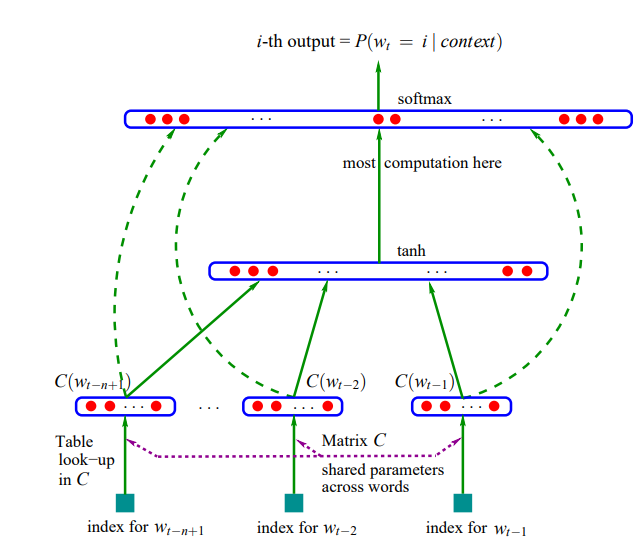

In [161]:
# We start with a random embedding 
# For each index, we have a point in R^2
emb_dim = 2
C = torch.randn((27,emb_dim))
print(C[:6])
C[5], itos[5] # coordinates of 5 which is 'e'

tensor([[-0.8370,  0.4488],
        [ 1.2673,  0.0583],
        [ 1.2381,  0.4250],
        [-1.0087, -0.3792],
        [-0.5276, -0.4598],
        [ 1.1373,  1.2321]])


(tensor([1.1373, 1.2321]), 'e')

In [156]:
# The lookup table to the embedding space C[i] can be thought of as the first linear layer in the bigger nn showed above
# Indeed, if we encode the indexes using one_hot_encoding, then C[i] = encoded_i dot C (easily verifiable by hand)
# So we input the encoded indexes and we treat C as weights  
# It's faster to just use C[i] so we will use that but it's a fun fact

print(C[5])
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # we convert to float bc by default it's a long float and C is just a float

tensor([0.2328, 1.6438])


tensor([0.2328, 1.6438])

In [157]:
# How to embed X in one shot ? 

print(C[5]) # embeds 5
print(C[[1,2,3]]) # embeds 1,2,3
print(C[torch.tensor([1,2,3,3])]) # works with tensors and the same element multiple times (not only with tensors)

print(C[X][0]) # embeding of the first context (['.','.','.'])
print(C[X].shape)

# it's an array of all matrices of embeded contexts
# a matrice of embeded context is created from a context list that is embeded just as in the example with C[[1,2,3]]
# So C[X][i] gives the embedding of the ith context
# C[X][i][j] gives the embedding of the jth int in the ith context

# To "give the embedding" of the jth int is to give its coordonates in the 2D space C

tensor([0.2328, 1.6438])
tensor([[ 0.1896,  1.1851],
        [ 0.3378, -1.1522],
        [ 0.1748,  2.2057]])
tensor([[ 0.1896,  1.1851],
        [ 0.3378, -1.1522],
        [ 0.1748,  2.2057],
        [ 0.1748,  2.2057]])
tensor([[ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.6540, -0.4395]])
torch.Size([16, 3, 2])


In [158]:
print(X[3,2]) #the 2nd int of the 3rd context is 13 here
print(C[X][3,2]) 
print(C[13]) 
# we see that to retrieve the embeding of a certain number in X,
# we can do that by looking up it's value in C[X] at the exact location we found it in X

print()
print(X[3])
print(C[X][3])
print(C[[ 5, 13, 13]])
# works for entiere contexts as well 

tensor(13)
tensor([-1.6467, -1.9367])
tensor([-1.6467, -1.9367])

tensor([ 5, 13, 13])
tensor([[ 0.2328,  1.6438],
        [-1.6467, -1.9367],
        [-1.6467, -1.9367]])
tensor([[ 0.2328,  1.6438],
        [-1.6467, -1.9367],
        [-1.6467, -1.9367]])


In [159]:
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

### Model 

Now that we have the embedding space, we create the model displayed in the image above.

In [166]:
# let's build the first hidden layer of the image 
input_size = block_size*emb_dim
nbr_neurons_1 = 100
W1 = torch.randn((input_size, nbr_neurons_1)) # wheights matrix of the first hidden layer
b1 = torch.randn(nbr_neurons_1) # for each neuron we have a random bias 
W1.shape, b1.shape

# The input size in not only block_size (nbr of chars in context) because each neuron is a coordinate of a char in the embedding space
# Each row of W1 corresponds to the weights connecting one input neuron to all neurons in the hidden layer
# Each column of W1 corresponds to the weights connecting all input neurons to one neuron in the hidden layer


(torch.Size([6, 100]), torch.Size([100]))

In [178]:
# We cannot simply perform emb @ W1 + b1 because as we said, emb is a list of embeded contexts (matrices)
print(emb.shape, W1.shape)

# we must concatenate the embeddings for each input layer 
print(emb[:,0,:]) # gives for each context, the embeding of the first char 
print(emb[:,0,:].shape)
conc_emb = torch.cat([emb[:,i,:] for i in range(block_size)], axis=1) # we concatenate the list of all the embedings of the chars in a context window
# we are doing the concatenation on the columns 
# So for each line, we have 6 numbers coresponding to 3 embedings in C
print(conc_emb, conc_emb.shape)

torch.Size([16, 3, 2]) torch.Size([6, 100])
tensor([[ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.2328,  1.6438],
        [-1.6467, -1.9367],
        [ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.9645, -0.7037],
        [-1.4357, -0.5062],
        [-0.7849, -0.5811],
        [ 0.8678, -0.1341],
        [ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.6540, -0.4395],
        [ 0.1896,  1.1851]])
torch.Size([16, 2])
tensor([[ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.2328,  1.6438],
        [ 0.6540, -0.4395,  0.2328,  1.6438, -1.6467, -1.9367],
        [ 0.2328,  1.6438, -1.6467, -1.9367, -1.6467, -1.9367],
        [-1.6467, -1.9367, -1.6467, -1.9367,  0.1896,  1.1851],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.9645, -0.7037],
        [ 0.6540, -0.4395,  0.9645, -0.

In [201]:
# a better way to create conc_emb is to use the unbind method
# it removes a dimension exactly like [emb[:,i,:] for i in range(block_size)]

#Ex : 
M = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

test_rows = torch.unbind(torch.tensor(M), 0) 
test_col = torch.unbind(torch.tensor(M), 1)

print(test_rows)
print(test_col)

conc_emb = torch.cat(torch.unbind(emb, 1), 1)
conc_emb, conc_emb.shape
 

(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))
(tensor([1, 4, 7]), tensor([2, 5, 8]), tensor([3, 6, 9]))


(tensor([[ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
         [ 0.6540, -0.4395,  0.6540, -0.4395,  0.2328,  1.6438],
         [ 0.6540, -0.4395,  0.2328,  1.6438, -1.6467, -1.9367],
         [ 0.2328,  1.6438, -1.6467, -1.9367, -1.6467, -1.9367],
         [-1.6467, -1.9367, -1.6467, -1.9367,  0.1896,  1.1851],
         [ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
         [ 0.6540, -0.4395,  0.6540, -0.4395,  0.9645, -0.7037],
         [ 0.6540, -0.4395,  0.9645, -0.7037, -1.4357, -0.5062],
         [ 0.9645, -0.7037, -1.4357, -0.5062, -0.7849, -0.5811],
         [-1.4357, -0.5062, -0.7849, -0.5811,  0.8678, -0.1341],
         [-0.7849, -0.5811,  0.8678, -0.1341, -0.7849, -0.5811],
         [ 0.8678, -0.1341, -0.7849, -0.5811,  0.1896,  1.1851],
         [ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
         [ 0.6540, -0.4395,  0.6540, -0.4395,  0.1896,  1.1851],
         [ 0.6540, -0.4395,  0.1896,  1.1851,  0.8678, -0.1341],
         [ 0.1896,  1.185

In [ ]:
# 3rd method : view method (like reshape in numpy)

a = torch.arange(18)
print(a, a.shape)

print(a.view(2,9))
print(a.view(3,3,2))

# we can reshape the tensor the way we wan't as long as the size is conserved
# It's extremely efficient thanks to the inner workings of torch
# Because each vector has a storage, which is the list of all its elements
# This is fixed and only its representation changes
# So we don't change/create/delete memory when using .view()
a.storage()

# whereas when we concatenate using bind, we create a whole new tensor with new storage --> inneficient

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]) torch.Size([18])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [ ]:
# let's use that to solve our original pb i.e multiply emb and W1
conc_emb = emb.view(emb.shape[0], input_size)
print(conc_emb, conc_emb.shape) # once again the same matrix 

h = conc_emb @ W1 + b1 # 16x6 @ (3*2)x100 + 100 = len(X)x(block_size*emb_dim) @ (block_size*emb_dim)x(nbr_neurons_1) + nbr_neurons_1
h, h.shape
# i.e., this is the list of outputs from the linear transformation for each example in X for each of our 100 neurons in the hidden layer

tensor([[ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.2328,  1.6438],
        [ 0.6540, -0.4395,  0.2328,  1.6438, -1.6467, -1.9367],
        [ 0.2328,  1.6438, -1.6467, -1.9367, -1.6467, -1.9367],
        [-1.6467, -1.9367, -1.6467, -1.9367,  0.1896,  1.1851],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.9645, -0.7037],
        [ 0.6540, -0.4395,  0.9645, -0.7037, -1.4357, -0.5062],
        [ 0.9645, -0.7037, -1.4357, -0.5062, -0.7849, -0.5811],
        [-1.4357, -0.5062, -0.7849, -0.5811,  0.8678, -0.1341],
        [-0.7849, -0.5811,  0.8678, -0.1341, -0.7849, -0.5811],
        [ 0.8678, -0.1341, -0.7849, -0.5811,  0.1896,  1.1851],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.6540, -0.4395],
        [ 0.6540, -0.4395,  0.6540, -0.4395,  0.1896,  1.1851],
        [ 0.6540, -0.4395,  0.1896,  1.1851,  0.8678, -0.1341],
        [ 0.1896,  1.1851,  0.8678, -0.1

(tensor([[-0.5717, -0.0940,  0.0099,  ...,  0.2800,  0.4531,  0.1712],
         [-2.1210, -5.3680,  0.9497,  ..., -0.9048,  0.5406,  0.6014],
         [ 1.9189,  7.0419,  0.4684,  ...,  4.3584,  2.8935,  2.1384],
         ...,
         [-1.7690, -4.1292,  0.8406,  ..., -0.5044,  0.5535,  0.4422],
         [ 0.2224,  0.4346, -0.6368,  ...,  0.0827,  2.0469,  3.1713],
         [-1.9091, -3.7511, -0.9479,  ..., -0.7523, -0.1957, -2.5487]]),
 torch.Size([16, 100]))

In [ ]:
h = torch.tanh(h) # non linear transformation 
h

tensor([[-0.5166, -0.0937,  0.0098,  ...,  0.2729,  0.4244,  0.1695],
        [-0.9717, -1.0000,  0.7397,  ..., -0.7186,  0.4934,  0.5380],
        [ 0.9578,  1.0000,  0.4369,  ...,  0.9997,  0.9939,  0.9726],
        ...,
        [-0.9435, -0.9995,  0.6861,  ..., -0.4656,  0.5031,  0.4155],
        [ 0.2188,  0.4091, -0.5627,  ...,  0.0825,  0.9672,  0.9965],
        [-0.9570, -0.9989, -0.7388,  ..., -0.6365, -0.1933, -0.9878]])

In [ ]:
# Let's build the second hidden layer
nbr_neurons_2 = 27 # because we have 27 chars
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2 
logits, logits.shape

# for each example, we have 27 outputs. But we wan't probabilities 

(tensor([[ -3.5496,  -9.3670,   8.6712, -13.6332,  -7.4738,  -6.7669,  -0.5470,
           -2.8845,   6.2842,  -4.2071, -11.6868,   2.3694,   2.0250,  -3.8473,
           -8.6834,   6.3667,  -3.4339,   7.9852,  -5.6332,  12.0850,  -1.2778,
            7.6859,  -3.2006,  -8.7749, -10.6890,  11.0093,  -1.1583],
         [ -8.6460,  -7.9001,  12.4981,   2.5935,   6.7613,   0.5031,  -5.1183,
            8.4441,  -4.0614,  -8.1566,   2.6357,   2.0751,   6.5486,   7.6617,
           -5.2188,   3.8316,  -3.4530,  -3.5067,  -4.6444,   0.1100,  -2.7529,
           -6.6181,  10.2301,   4.6632,   9.6561,  15.7826, -17.4793],
         [ -3.1782, -11.9658,  -8.1321,  -5.7926, -12.6076,  -3.1866,   6.8975,
           -5.1965,   5.1844,  -0.4907,  -2.4832,  -0.1741,  -7.6713, -11.4869,
          -13.6587,  -7.5921,   4.1567,  14.0303,  -0.6076,   6.4581, -18.0922,
           16.1184,  -9.2414,   3.2319, -15.3715,  -1.8448,   1.6153],
         [  4.9805,  -0.1910, -11.4569,   2.4758,   4.3639,  12.629

In [245]:
# Thus, we (manually) create the softmax

counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
print(prob.shape)
print(prob)
prob.sum(1, keepdim=True) # we see that each row sums to 1 (these are probability distributions as we wanted)

torch.Size([16, 27])
tensor([[1.1507e-07, 3.4237e-10, 2.3357e-02, 4.8054e-12, 2.2737e-09, 4.6100e-09,
         2.3172e-06, 2.2378e-07, 2.1466e-03, 5.9626e-08, 3.3654e-11, 4.2810e-05,
         3.0337e-05, 8.5440e-08, 6.7824e-10, 2.3311e-03, 1.2919e-07, 1.1762e-02,
         1.4325e-08, 7.0960e-01, 1.1158e-06, 8.7191e-03, 1.6313e-07, 6.1892e-10,
         9.1278e-11, 2.4201e-01, 1.2574e-06],
        [2.3540e-11, 4.9631e-11, 3.5857e-02, 1.7909e-06, 1.1565e-04, 2.2142e-07,
         8.0144e-10, 6.2220e-04, 2.3062e-09, 3.8403e-11, 1.8681e-06, 1.0664e-06,
         9.3490e-05, 2.8455e-04, 7.2480e-10, 6.1766e-06, 4.2373e-09, 4.0158e-09,
         1.2873e-09, 1.4945e-07, 8.5340e-09, 1.7887e-10, 3.7120e-03, 1.4188e-05,
         2.0908e-03, 9.5720e-01, 3.4319e-15],
        [3.7051e-09, 5.6544e-13, 2.6141e-11, 2.7125e-10, 2.9761e-13, 3.6740e-09,
         8.8024e-05, 4.9235e-10, 1.5872e-05, 5.4446e-08, 7.4243e-09, 7.4728e-08,
         4.1444e-11, 9.1282e-13, 1.0404e-13, 4.4861e-11, 5.6795e-06, 1.1025e-

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [ ]:
print(prob[torch.arange(X.shape[0]), Y]) # tensor of the probabilities of the correct following chars 

loss = -prob[torch.arange(X.shape[0]), Y].log().mean() # negative log likelihood ~ cross_entropy
loss

# It's less efficient to implement ourselves the cross entropy loss (no memory re allocation, explicit gradient form = better backward pass, NaN handling...)

tensor([4.6100e-09, 2.8455e-04, 9.1282e-13, 1.0308e-06, 4.5602e-04, 2.3311e-03,
        1.3952e-05, 9.5981e-07, 9.1923e-07, 9.6249e-15, 1.2211e-05, 1.1066e-08,
        3.4237e-10, 8.4303e-03, 1.6745e-09, 1.1702e-10])


tensor(15.8195)

### Recap up to this point and training

We re implement the model in a condensed way and train it using backpropagation.

In [250]:
X.shape, Y.shape # dataset

(torch.Size([16, 3]), torch.Size([16]))

In [ ]:
# hyper parameters
emb_dim = 2
block_size = 3
nbr_neurons = 100
step = 0.1

# constants
nbr_chars = 27

In [387]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((nbr_chars, 2), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, nbr_chars), generator=g)
b2 = torch.randn(nbr_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

In [353]:
sum([p.nelement() for p in parameters])

3481

In [354]:
# The training / optimization 
for p in parameters:
    p.requires_grad = True # so that the gradient descent concerns all the params 

for _ in range(10):
    # Forward pass 
    emb = C[X] #(16, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y) 
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    for p in parameters:
        p.data += -step * p.grad 
    
# It's that good because we are overfitting 16 examples 

19.505229949951172
17.084487915039062
15.776532173156738
14.833340644836426
14.002604484558105
13.253260612487793
12.579916954040527
11.983101844787598
11.470492362976074
11.05185604095459


In [364]:
# Let's now create X and Y with all the words 

X,Y = [], []
for w in words:
    context = [0] * block_size # create the empty list of appropriate size 0's are "."
    for ch in w + '.': # add a dot at the end of the word 
        ix = stoi[ch] # retrieve the index of the ch
        X.append(context) 
        Y.append(ix) # target is the index of the ch
        context = context[1:] + [ix] # crop to the left and add the next index to the right 

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

torch.Size([228146, 3])
torch.Size([228146])


In [356]:
# We now train on the whole dataset 
for p in parameters:
    p.requires_grad = True # so that the gradient descent concerns all the params 

for _ in range(10):
    # Forward pass 
    emb = C[X] #(16, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y) 
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    for p in parameters:
        p.data += -step * p.grad 

# We notice that the loss decreases much more slowly
# Also, each iteration takes time, we will use minibatching to adress that

10.709586143493652
10.407631874084473
10.127808570861816
9.864364624023438
9.614501953125
9.376440048217773
9.148944854736328
8.931110382080078
8.722230911254883
8.521748542785645


### Mini batch training

The idea of mini batch training is to train the model on a small random subset of the data at a time.

The model is trained on the subset, and the weights are updated.

It is used because it balances the trade-off between the efficiency of stochastic gradient descent (SGD) and the stability of full-batch gradient descent.

It works because the mini-batch gradient is a good approximation of the full-batch gradient, and it is more computationally efficient than full-batch training.

The randomness is responsible for the up and downs in the loss curve.

Pros:

- Faster convergence compared to full-batch training.
- More stable updates compared to SGD.
- Better utilization of hardware resources.

Cons:

- Requires tuning of the batch size.
- May still be computationally expensive for very large datasets.
- Can introduce noise in the gradient updates.

#### Note : It's better to have an approximate of the gradient and make much more step than having the exact gradient and make less step.

In [357]:
ixs = torch.randint(0, X.shape[0], (32,)) # tensor of batch_size integers 
print(X[ixs][:5], X[ixs].shape) # X[ixs] --> tensor of batch_size rows of X located by the random ixs
Y[ixs][:5], Y[ix].shape # Corresponding ground thruths 

tensor([[16, 16,  5],
        [ 1, 22,  5],
        [ 0,  0,  1],
        [12,  1, 14],
        [20, 15, 14]]) torch.Size([32, 3])


(tensor([12, 14, 14,  7,  0]), torch.Size([]))

In [358]:
batch_size = 32

def minibatch_training(n):
    for p in parameters:
        p.requires_grad = True # so that the gradient descent concerns all the params 

    for _ in range(n):
        # minibatch construct 
        ixs = torch.randint(0, X.shape[0], (batch_size,)) 

        # Forward pass 
        emb = C[X[ixs]] 
        h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits,Y[ixs]) 
        print(loss.item())

        # Backward pass
        for p in parameters:
            p.grad = None # reset the gradients more efficiently than setting them to 0

        loss.backward()

        # update
        for p in parameters:
            p.data += -step * p.grad 
    
    return loss 
minibatch_training(100)
# Almost instantanous results with more iterations --> loss decreases faster 

8.882829666137695
10.801115989685059
7.943039894104004
7.011079788208008
6.5519490242004395
8.30522632598877
8.014720916748047
6.466509819030762
8.55371379852295
5.900352478027344
6.155949592590332
5.29543924331665
7.389379024505615
7.275687217712402
6.925985813140869
6.389536380767822
5.427316188812256
6.787538051605225
6.097088813781738
6.806061744689941
6.811946392059326
5.4024200439453125
5.4247965812683105
6.2266411781311035
5.264076232910156
5.740921974182129
6.0063910484313965
5.455480575561523
3.5943753719329834
5.9935760498046875
4.637293338775635
5.897049903869629
4.6142706871032715
5.17737340927124
5.170350074768066
4.187561988830566
4.823225975036621
4.599111080169678
5.0540452003479
6.335184097290039
4.921667575836182
4.975425720214844
4.037680625915527
4.512980937957764
3.8087456226348877
4.570362091064453
4.525307655334473
5.6054205894470215
3.865475654602051
3.728961944580078
4.128366947174072
4.2855544090271
4.192192077636719
4.775416374206543
4.4179911613464355
4.5792

tensor(3.6780, grad_fn=<NllLossBackward0>)

In [359]:
minibatch_training(100)
# converges to ~2.5 on mini batches 

2.802981376647949
3.690436601638794
3.2263078689575195
3.2670395374298096
3.412766933441162
3.9181673526763916
3.072103500366211
3.11832332611084
4.5526862144470215
3.1938815116882324
3.3737168312072754
2.32289719581604
4.031500816345215
3.0328867435455322
3.6910505294799805
2.7124459743499756
2.8312764167785645
3.4815785884857178
3.9228270053863525
3.3733465671539307
2.983792304992676
3.144747257232666
3.1721560955047607
2.836831569671631
2.8461194038391113
3.8860983848571777
3.0092175006866455
2.7988317012786865
2.9723446369171143
2.6722371578216553
3.9351675510406494
3.6244308948516846
3.2615673542022705
3.3399245738983154
2.635676622390747
3.102322578430176
3.6025097370147705
3.9648807048797607
3.850877285003662
3.863408327102661
3.1851162910461426
2.7407729625701904
2.879758358001709
3.1394248008728027
3.421422243118286
3.658778667449951
3.513770341873169
2.8710222244262695
3.198704481124878
3.5511605739593506
3.2229716777801514
2.8258988857269287
3.5184624195098877
3.854079961776

tensor(3.2661, grad_fn=<NllLossBackward0>)

In [360]:
# The loss on the whole data is : 
emb = C[X] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y) 
print(loss.item())

3.0183582305908203


### Finding the optimal learning rate

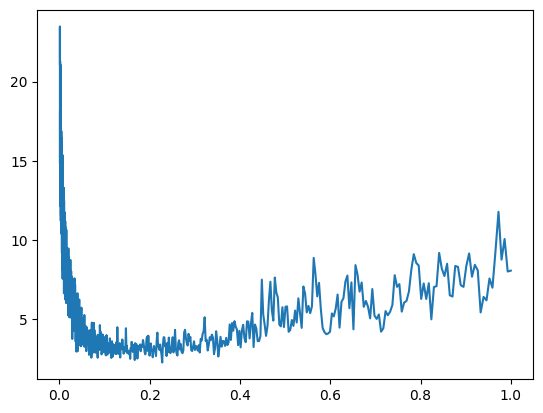

In [ ]:

# empirically, we see that above 1, it's not optimizing/unstable and below 0.001 it's too slow 
# So now, we will search over possible candidates 
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre #from 0.001 to 1 exponentielly stepped 

lri = [] 
lossi = []
for p in parameters:
        p.requires_grad = True # so that the gradient descent concerns all the params 

for i in range(1000):
    # minibatch construct 
    ixs = torch.randint(0, X.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[X[ixs]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats on lrs
    lri.append(lr.item())
    lossi.append(loss.item())


plt.plot(lri, lossi)
# we see that the optimal rate can be approximated 
# Here it's around 0.1
# So we should set it at 0.1
# Then, we can lower it as the nbr of iterations increases (learning rate decay)